In [39]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
import datetime
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from icelakes.utilities import convert_time_to_string
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

In [4]:
class dictobj:
    def __init__(self, in_dict:dict):
        assert isinstance(in_dict, dict)
        for key, val in in_dict.items():
            setattr(self, key, val)
    #-------------------------------------------------------------------------------------
    def plot_detected(self, fig_dir='figs', verbose=False, min_width=0.0, min_depth=0.0, print_mframe_info=True):

        if len(self.detection_2nd_returns['h'])>0:
            lake_minh = np.min(self.detection_2nd_returns['h'])
        else: return
        lake_max_depth = np.abs(self.main_peak - np.min(self.detection_2nd_returns['h']))
        lake_segment_length = np.abs(np.max(self.detection_2nd_returns['xatc']) - np.min(self.detection_2nd_returns['xatc']))
        lake_maxh = np.min((self.mframe_data['peak'].max(), self.main_peak+0.5*lake_max_depth))
        buffer_bottom = np.max((0.5*lake_max_depth, 2.0))
        lake_minh_plot = lake_minh - buffer_bottom
        buffer_top = (lake_maxh - lake_minh_plot) * 0.5
        lake_maxh_plot = lake_maxh + buffer_top
        ylms = (lake_minh_plot, lake_maxh_plot)
        xlms = (0.0, self.mframe_data.xatc_max.max())

        if (lake_max_depth > min_depth) & (lake_segment_length > min_width):
            fig, ax = plt.subplots(figsize=[9, 5], dpi=100)

            # plot the ATL03 photon data
            scatt = ax.scatter(self.photon_data.xatc, self.photon_data.h,s=5, c=self.photon_data.snr, alpha=1, 
                               edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)
            p_scatt = ax.scatter([-9999]*4, [-9999]*4, s=15, c=[0.0,0.25,0.75,1.0], alpha=1, edgecolors='none', cmap=cmc.lajolla, 
                                 vmin=0, vmax=1, label='ATL03 photons')

            # plot surface elevation
            for xtent in self.surface_extent_detection:
                ax.plot(xtent, [self.surface_elevation, self.surface_elevation], 'g-', lw=3)
            p_surf_elev, = ax.plot([-9999]*2, [-9999]*2, 'g-', lw=3, label='lake surface')

            # plot the second returns from detection
            for j, prom in enumerate(self.detection_2nd_returns['prom']):
                ax.plot(self.detection_2nd_returns['xatc'][j], self.detection_2nd_returns['h'][j], 
                                        marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*8)
            p_2nd_return, = ax.plot(-9999, -9999, marker='o', mfc='none', mec='b', ls='None', ms=3, label='second returns')

            # plot mframe bounds
            ymin, ymax = ax.get_ylim()
            mframe_bounds_xatc = list(self.mframe_data['xatc_min']) + [self.mframe_data['xatc_max'].iloc[-1]]
            for xmframe in mframe_bounds_xatc:
                ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

            # visualize which segments initially passed
            for i, passing in enumerate(self.mframe_data['lake_qual_pass']):
                mf = self.mframe_data.iloc[i]
                if passing:
                    xy = (mf.xatc_min, ylms[0])
                    width = mf.xatc_max - mf.xatc_min
                    height = ylms[1] - ylms[0]
                    rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=(0,0,1,0.1), zorder=-1000, label='major frame passed lake check')
                    p_passed = ax.add_patch(rct)
                p_mfpeak, = ax.plot((mf.xatc_min,mf.xatc_max), (mf.peak,mf.peak),'k-',lw=0.5, label='major frame peak')

            # add a legend
            hdls = [p_scatt, p_surf_elev, p_2nd_return, p_mfpeak, p_passed]
            ax.legend(handles=hdls, loc='lower left', fontsize=7, scatterpoints=4)

            # add the colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='4%', pad=0.05)
            cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
            cbar.ax.get_yaxis().set_ticks([])
            for j, lab in enumerate([0.2, 0.4, 0.6, 0.8]):
                cbar.ax.text(.5, lab, '%.1f'%lab, ha='center', va='center', fontweight='black')
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel('photon density', rotation=270, fontsize=8)

            # add labels and description in title
            txt  = 'ICESat-2 Lake Detection: %s, ' % ('Greenland Ice Sheet' if self.lat>=0 else 'Antarctic Ice Sheet')
            txt += '%s Melt Season' % self.melt_season
            fig.suptitle(txt, y=0.95, fontsize=14)

            txt  = 'location: %s, %s (area: %s) | ' % (self.lat_str, self.lon_str, self.polygon_name)
            txt += 'time: %s UTC | surface elevation: %.2f m\n' % (self.date_time, self.surface_elevation)
            txt += 'RGT %s %s cycle %i | ' % (self.rgt, self.gtx.upper(), self.cycle_number)
            txt += 'beam %i (%s, %s spacecraft orientation) | ' % (self.beam_number, self.beam_strength, self.sc_orient)
            txt += 'granule ID: %s' % self.granule_id
            ax.set_title(txt, fontsize=8)

            ax.set_ylabel('elevation above geoid [m]',fontsize=8)
            ax.tick_params(axis='x', which='major', labelsize=7)
            ax.tick_params(axis='y', which='major', labelsize=6)
            # set limits
            ax.set_ylim(ylms)
            ax.set_xlim(xlms)

            # add latitude
            #_________________________________________________________
            lx = self.photon_data.sort_values(by='lat').iloc[[0,-1]][['lat','xatc']].reset_index(drop=True)
            lat = np.array(lx.lat)
            xatc = np.array(lx.xatc)
            def forward(x):
                return lat[0] + x * (lat[1] - lat[0]) / (xatc[1] - xatc[0])
            def inverse(l):
                return xatc[0] + l * (xatc[1] - xatc[0]) / (lat[1] - lat[0])
            secax = ax.secondary_xaxis(-0.065, functions=(forward, inverse))
            secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            secax.set_xlabel('latitude / along-track distance',fontsize=8,labelpad=0)
            secax.tick_params(axis='both', which='major', labelsize=7)
            secax.ticklabel_format(useOffset=False) # show actual readable latitude values

            # rename x ticks
            xticklabs = ['%g km' % (xt/1000) for xt in list(ax.get_xticks())]
            ticks = ax.get_xticks()
            ax.set_xticks(ticks)
            ax.set_xticklabels(xticklabs)

            # add mframe info text
            if print_mframe_info:
                txt  = 'mframe:\n' % (mf.name%1000)
                txt += 'photons:\n' % mf.n_phot
                txt += 'peak:\n'
                txt += 'flat:\n'
                txt += 'SNR surf all:\n'
                txt += 'SNR surf above:\n'
                txt += 'SNR up:\n'
                txt += 'SNR low:\n'
                txt += '2nds:\n'
                txt += '2nds strength:\n'
                txt += '2nds number:\n'
                txt += '2nds spread:\n'
                txt += '2nds align:\n'
                txt += '2nds quality:\n'
                txt += 'pass:'
                # trans = ax.get_xaxis_transform()
                bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                ax.text(-0.005, 0.98, txt, transform=ax.transAxes, fontsize=4, ha='right', va='top', bbox=bbox)
                for i,loc in enumerate(self.mframe_data['xatc']):
                    mf = self.mframe_data.iloc[i]
                    txt  = '%i\n' % (mf.name%1000)
                    txt += '%i\n' % mf.n_phot
                    txt += '%.2f\n' % mf.peak
                    txt += '%s\n' % ('Yes.' if mf.is_flat else 'No.')
                    txt += '%i\n' % np.round(mf.snr_surf)
                    txt += '%i\n' % np.round(mf.snr_allabove)
                    txt += '%i\n' % np.round(mf.snr_upper)
                    txt += '%i\n' % np.round(mf.snr_lower)
                    txt += '%i%%\n' % np.round(mf.ratio_2nd_returns*100)
                    txt += '%.2f\n' % mf.quality_secondreturns
                    txt += '%.2f\n' % mf.length_penalty
                    txt += '%.2f\n' % mf.range_penalty
                    txt += '%.2f\n' % mf.alignment_penalty
                    txt += '%.2f\n' % mf.quality_summary
                    txt += '%s' % ('Yes.' if mf.lake_qual_pass else 'No.')
                    trans = ax.get_xaxis_transform()
                    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                    ax.text(loc, 0.98, txt, transform=trans, fontsize=4,ha='center', va='top', bbox=bbox)

            # add detection quality description
            txt  = 'LAKE QUALITY: %6.4f'%self.detection_quality
            txt += '\n---------------------------\n'
            txt += '2nd returns: %6.4f\n' % self.detection_quality_info['strength_2nd_returns']
            txt += 'alignment: %6.4f\n' % self.detection_quality_info['qual_alignment']
            txt += 'depth: %6.4f\n' % self.detection_quality_info['lake_depth']
            txt += 'length: %6.4f\n' % self.detection_quality_info['lake_length']
            txt += 'depth range: %6.4f' % self.detection_quality_info['h_range_2nd_returns']
            bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
            ax.text(0.99, 0.02, txt, transform=ax.transAxes, ha='right', va='bottom',fontsize=6, weight='bold', bbox=bbox)

            fig.patch.set_facecolor('white')
            fig.tight_layout()
            ax.set_ylim(ylms)
            ax.set_xlim(xlms)

            plt.close(fig)

            return fig

In [5]:
def convert_time_to_string(dt):
    epoch = dt + datetime.datetime.timestamp(datetime.datetime(2018,1,1))
    return datetime.datetime.fromtimestamp(epoch).strftime("%Y-%m-%d, %H:%M:%S")

def read_melt_lake_h5(fn):
    
    lakedict = {}
    with h5py.File(fn, 'r') as f:

        # metadata
        for key in f['properties'].keys(): 
            lakedict[key] = f['properties'][key][()]

        # photon data
        photon_data_dict = {}
        for key in f['photon_data'].keys():
            photon_data_dict[key] = f['photon_data'][key][()]
        lakedict['photon_data'] = pd.DataFrame(photon_data_dict)

        # mframe data
        mframe_data_dict = {}
        for key in f['mframe_data'].keys():
            mframe_data_dict[key] = f['mframe_data'][key][()]
        lakedict['mframe_data'] = pd.DataFrame(mframe_data_dict).set_index('mframe')    

        # second returns data
        det_2nds_dict = {}
        for key in f['detection_2nd_returns'].keys():
            det_2nds_dict[key] = f['detection_2nd_returns'][key][()]
        lakedict['detection_2nd_returns'] = det_2nds_dict

        # quality assessment data
        qual_dict = {}
        for key in f['detection_quality_info'].keys():
            qual_dict[key] = f['detection_quality_info'][key][()]
        lakedict['detection_quality_info'] = qual_dict
        
        # re-nest the lake extent segments
        def re_nest_extent(x): return [[x[i], x[i+1]] for i in np.arange(0,2,len(x))]
        lakedict['surface_extent_detection'] = re_nest_extent(lakedict['surface_extent_detection'])
        lakedict['lat_surface_extent_detection'] = re_nest_extent(lakedict['lat_surface_extent_detection'])
        
        lakedict['date_time'] = convert_time_to_string(lakedict['mframe_data']['dt'].mean())
        
        return lakedict
    

In [41]:
##########################################################################################
def find_flat_lake_surfaces(df_mframe, df, bin_height_coarse=0.2, bin_height_fine=0.01, smoothing_histogram=0.1, buffer=30.0,
                            width_surf=0.1, width_buff=0.35, rel_dens_upper_thresh=5, rel_dens_lower_thresh=2,
                            min_phot=30, min_snr_surface=10, min_snr_vs_all_above=100):
    
    # initialize arrays for major-frame-level photon stats
    peak_locs = np.full(len(df_mframe), np.nan, dtype=np.double)
    is_flat = np.full_like(peak_locs, False, dtype=np.bool_)
    surf_snr = np.full_like(peak_locs, 0.0, dtype=np.double)
    upper_snr = np.full_like(peak_locs, 0.0, dtype=np.double)
    lower_snr = np.full_like(peak_locs, 0.0, dtype=np.double)
    all_above_snr = np.full_like(peak_locs, 0.0, dtype=np.double)
    
    mids = []
    curves = []
    hists = []
    
    for i, mframe in enumerate(df_mframe.index):
        
        try:
        
            # select the photons in the major frame
            selector_segment = (df.mframe == mframe)
            dfseg = df[selector_segment]

            # check if there are enough photons in the segment
            if len(dfseg) < min_phot:
                is_flat[i] = False

            # find peaks
            else:
                # find main broad peak
                ##############################################################################################
                #             ******************working version******************
                #             bins_coarse1 = np.arange(start=dfseg.h.min(), stop=dfseg.h.max(), step=bin_height_coarse)
                #             hist_mid1 = bins_coarse1[:-1] + 0.5 * bin_height_coarse
                #             peak_loc1 = hist_mid1[np.argmax(np.histogram(dfseg.h, bins=bins_coarse1)[0])]
                ##############################################################################################
                promininece_threshold = 0.1
                bins_coarse1 = np.arange(start=dfseg.h.min(), stop=dfseg.h.max(), step=bin_height_coarse)
                hist_mid1 = bins_coarse1[:-1] + 0.5 * bin_height_coarse
                broad_hist = np.array(pd.Series(np.histogram(dfseg.h, bins=bins_coarse1)[0]).rolling(3,center=True,min_periods=1).mean())
                broad_hist /= np.max(broad_hist)
                peaks, peak_props = find_peaks(broad_hist, height=promininece_threshold, distance=1.0, prominence=promininece_threshold)
                peak_hs = hist_mid1[peaks]
                if len(peaks) > 1:
                    peak_proms = peak_props['prominences']
                    idx_2highest = np.flip(np.argsort(peak_proms))[:2]
                    pks_h = np.sort(peak_hs[idx_2highest])
                    peak_loc1 = np.max(pks_h)
                else:
                    peak_loc1 = hist_mid1[np.argmax(broad_hist)]

                ##############################################################################################           

                # decrease bin width and find finer peak
                bins_coarse2 = np.arange(start=peak_loc1-buffer, stop=peak_loc1+buffer, step=bin_height_fine)
                hist_mid2 = bins_coarse2[:-1] + 0.5 * bin_height_fine
                hist = np.histogram(dfseg.h, bins=bins_coarse2)
                window_size = int(smoothing_histogram/bin_height_fine)
                hist_vals = hist[0]
                hist_vals_smoothed = np.array(pd.Series(hist_vals).rolling(window_size,center=True,min_periods=1).mean())
                peak_loc2 = hist_mid2[np.argmax(hist_vals_smoothed)]
                peak_locs[i] = peak_loc2
                
                mids.append(hist_mid2)
                hists.append(hist_vals/np.max(hist_vals_smoothed))
                curves.append(hist_vals_smoothed/np.max(hist_vals_smoothed))

                # calculate relative photon densities
                peak_upper = peak_loc2 + width_surf
                peak_lower = peak_loc2 - width_surf
                above_upper = peak_upper + width_buff
                below_lower = peak_lower - width_buff
                sum_peak = np.sum((dfseg.h > peak_lower) & (dfseg.h < peak_upper))
                sum_above = np.sum((dfseg.h > peak_upper) & (dfseg.h < above_upper))
                sum_below = np.sum((dfseg.h > below_lower) & (dfseg.h < peak_lower))
                sum_all_above = np.sum(dfseg.h > peak_upper)
                h_range_all_above = dfseg.h.max() - peak_upper
                noise_rate_all_above = sum_all_above / h_range_all_above
                signal_rate = sum_peak / (width_surf*2)
                rel_dens_upper = 1000 if sum_above==0 else signal_rate / (sum_above / width_buff)
                rel_dens_lower = 1000 if sum_below==0 else signal_rate / (sum_below / width_buff)
                noise_rate = (dfseg.h.count() - sum_peak) / (dfseg.h.max() - dfseg.h.min() - width_surf*2)
                snr_surface = signal_rate / noise_rate
                snr_allabove = 1000 if noise_rate_all_above == 0 else signal_rate / noise_rate_all_above

                # check for flat surface, if found calculate SNR and look for bottom return
                is_flat_like_lake = (rel_dens_upper > rel_dens_upper_thresh) \
                                    & (rel_dens_lower > rel_dens_lower_thresh) \
                                    & (snr_surface > min_snr_surface) \
                                    & (snr_allabove > min_snr_vs_all_above)
                is_flat[i] = is_flat_like_lake

                # print('%4i, %5s, %4i, %4i, %4i' % (mframe, is_flat[i], snr_surface, rel_dens_lower, rel_dens_upper))
                
        except: 
            print('Something went wrong with checking if mframe %i is flat...' % mframe)
            traceback.print_exc()
    
    print('(%i / %i were flat)' % (df_mframe.is_flat.sum(), df_mframe.is_flat.count()))

    return mids, hists, curves

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

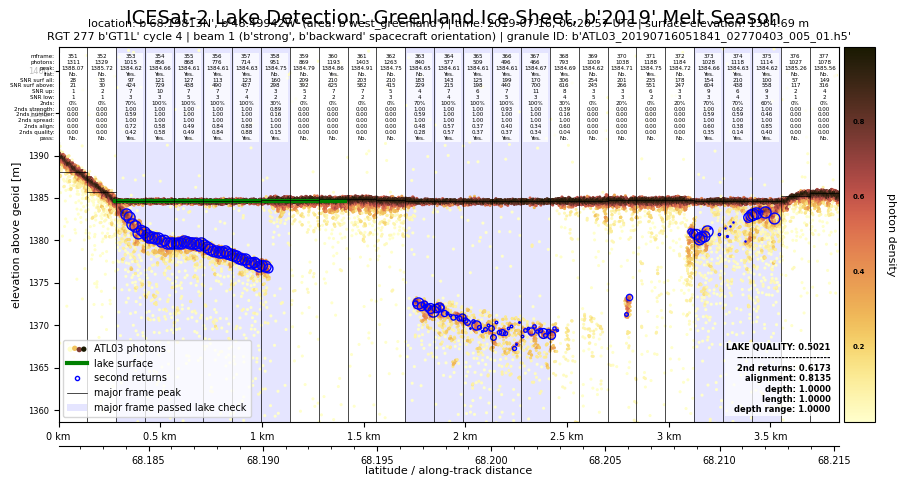

In [42]:
fn = 'WAIS_region_comps/lake_04978_GrIS_2019_west_greenland_ATL03_20190716051841_02770403_005_01_gt1l.h5'
lakedict = read_melt_lake_h5(fn)
thislake = dictobj(lakedict)
fig = thislake.plot_detected(print_mframe_info=True)
display(fig)

In [61]:
thismf

alignment_penalty                   0.0
dt                       48489656.91419
is_flat                           False
lake_qual_pass                    False
lat                           68.181693
length_penalty                      0.0
lon                          -48.494215
n_phot                             1311
peak                        1388.066763
quality_secondreturns               0.0
quality_summary                     0.0
range_penalty                       0.0
ratio_2nd_returns                   0.0
snr_allabove                  21.492108
snr_lower                      1.237261
snr_surf                      28.245334
snr_upper                      1.348958
xatc                          70.632811
xatc_max                     141.265621
xatc_min                            0.0
Name: 57975351, dtype: object

In [102]:
plt.close('all')
lakedict = read_melt_lake_h5(fn)
lk = dictobj(lakedict)
plt.rcParams.update({'font.size': 5})

fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
xlms = (-0.05 * lk.mframe_data.xatc_max.max(), lk.mframe_data.xatc_max.max()+650)
ylms = (1360, 1395)
ax.set_xlim(xlms)
ax.set_ylim(ylms)
ax.set_ylabel('elevation above geoid [m]')
ax.set_xlabel('along_track distance [m]')

scatt = []
#for mf in lk.mframe_data.index:
mids, hists, curves = find_flat_lake_surfaces(lk.mframe_data, lk.photon_data)
for i, mf in enumerate(lk.mframe_data.index):
    thismf = lk.mframe_data.iloc[i]
    dfmf = lk.photon_data[lk.photon_data.mframe == mf].copy()
    scatt.append(ax.scatter(dfmf.xatc, dfmf.h, s=2, c='k', alpha=0.3, edgecolors='none'))
    curv, = ax.plot(dfmf.xatc.max()+30+curves[i]*150, mids[i], 'k-')
    xvals = [dfmf.xatc.min(), dfmf.xatc.max()+30+150*np.max(curves[i])]
    yvals = [mids[i][np.argmax(curves[i])]]*2
    pk1, = ax.plot(xvals, yvals, 'r-')
    fs = 7
    side1, = ax.plot([thismf.xatc_min]*2, ylms , 'k-', lw = 0.5)
    side2, = ax.plot([thismf.xatc_max]*2, ylms , 'k-', lw = 0.5)
    txxts = []
    txxts.append(ax.text(xvals[1]+30, yvals[0]+4.0, 'photon\ndensity\nratios:', va='center', 
                         ha='left', c='k', weight='bold', fontsize=fs-1))
    col = 'r' if thismf.snr_surf < 10 else 'g'
    txxts.append(ax.text(xvals[1]+30, yvals[0], '→ %.1f'%thismf.snr_surf, va='center', 
                         ha='left', c=col, weight='bold', fontsize=fs))
    col = 'r' if thismf.snr_upper < 5 else 'g'
    txxts.append(ax.text(xvals[1]+30, yvals[0]+1.0, '↑ %.1f'%thismf.snr_upper, va='center',
                          ha='left', c=col, weight='bold', fontsize=fs))
    col = 'r' if thismf.snr_allabove < 100 else 'g'
    txxts.append(ax.text(xvals[1]+30, yvals[0]+2.0, '⇈ %.1f'%thismf.snr_allabove, va='center', 
                         ha='left', c=col, weight='bold', fontsize=fs))
    col = 'r' if thismf.snr_lower < 2 else 'g'
    txxts.append(ax.text(xvals[1]+30, yvals[0]-1.0, '↓ %.1f'%thismf.snr_lower, va='center', 
                         ha='left', c=col, weight='bold', fontsize=fs))
    col = 'g' if thismf.is_flat else 'r'
    txt = 'flat!' if thismf.is_flat else 'NOT\nflat!'
    txxts.append(ax.text(xvals[1]+30, yvals[0]-4.0, '⇒\n%s'%txt, va='center',
                         ha='center', c=col, weight='bold', fontsize=fs+2))

    plt.savefig('explainer_figs/findflat_%03i.jpg' % i, dpi=300, bbox_inches='tight', pad_inches=0.02)
    
    for t in txxts: t.remove()
    curv.remove()
    pk1.remove()
    
    if not thismf.is_flat:
        scatt[-1].remove()
        side1.remove()
        side2.remove()

i += 1
plt.savefig('explainer_figs/findflat_%03i.jpg' % i, dpi=300, bbox_inches='tight', pad_inches=0.02)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(15 / 27 were flat)


In [104]:
plt.close('all')
lakedict = read_melt_lake_h5(fn)
lk = dictobj(lakedict)
plt.rcParams.update({'font.size': 5})

fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
xlms = (-0.05 * lk.mframe_data.xatc_max.max(), lk.mframe_data.xatc_max.max()+650)
ylms = (1360, 1395)
ax.set_xlim(xlms)
ax.set_ylim(ylms)
ax.set_ylabel('elevation above geoid [m]')
ax.set_xlabel('along_track distance [m]')

ax.scatter(lk.photon_data.xatc, lk.photon_data.h, s=2, c='k', alpha=0.3, edgecolors='none')
plt.savefig('explainer_figs/0starter1.jpg', dpi=300, bbox_inches='tight', pad_inches=0.02)
for i, mf in enumerate(lk.mframe_data.index):
    thismf = lk.mframe_data.iloc[i]
    side1, = ax.plot([thismf.xatc_min]*2, ylms , 'k-', lw = 0.5)
    side2, = ax.plot([thismf.xatc_max]*2, ylms , 'k-', lw = 0.5)
plt.savefig('explainer_figs/0starter2.jpg', dpi=300, bbox_inches='tight', pad_inches=0.02)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [118]:
lk.mframe_data

,alignment_penalty,dt,is_flat,lake_qual_pass,lat,length_penalty,lon,n_phot,peak,quality_secondreturns,quality_summary,range_penalty,ratio_2nd_returns,snr_allabove,snr_lower,snr_surf,snr_upper,xatc,xatc_max,xatc_min
mframe,,,,,,,,,,,,,,,,,,,,
57975351,0.000000,4.848966e+07,False,False,68.181693,0.000000,-48.494215,1311,1388.066763,0.000000,0.000000,0.0,0.0,21.492108,1.237261,28.245334,1.348958,70.632811,141.265621,0.000000
57975352,0.000000,4.848966e+07,False,False,68.182954,0.000000,-48.494624,1329,1385.718746,0.000000,0.000000,0.0,0.0,29.502976,1.287097,32.560517,1.546512,212.791018,283.689709,141.892326
57975353,0.719720,4.848966e+07,True,True,68.184165,0.585662,-48.495016,1015,1384.620075,1.000000,0.421513,1.0,0.7,423.899505,3.291667,97.171898,6.689516,354.841136,425.330270,284.352002
57975354,0.581638,4.848966e+07,True,True,68.185470,1.000000,-48.495419,856,1384.661311,1.000000,0.581638,1.0,1.0,729.094884,2.804965,120.945428,10.407895,497.030077,568.304107,425.756047
57975355,0.489739,4.848966e+07,True,True,68.186743,1.000000,-48.495820,868,1384.614660,1.000000,0.489739,1.0,1.0,437.529852,4.711538,126.639782,6.915323,638.971216,709.333394,568.609037
57975356,0.837855,4.848966e+07,True,True,68.188006,1.000000,-48.496218,776,1384.614782,1.000000,0.837855,1.0,1.0,490.263284,2.802846,113.476244,6.759804,780.758398,851.618175,709.898622
57975357,0.883306,4.848966e+07,True,True,68.189294,1.000000,-48.496631,714,1384.631289,1.000000,0.883306,1.0,1.0,437.452807,4.287500,123.039310,6.596154,923.161762,994.188344,852.135180
57975358,1.000000,4.848966e+07,False,True,68.190600,0.164317,-48.497051,951,1384.746870,0.893875,0.146879,1.0,0.3,298.172042,2.056420,159.617697,3.409677,1065.515982,1135.944694,995.087271
57975359,0.000000,4.848966e+07,False,False,68.191851,0.000000,-48.497443,869,1384.787201,0.000000,0.000000,0.0,0.0,391.854804,2.403696,208.943928,4.864173,1207.527044,1278.409497,1136.644591


In [120]:
plt.close('all')
lakedict = read_melt_lake_h5(fn)
lk = dictobj(lakedict)
plt.rcParams.update({'font.size': 5})

fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
xlms = (-0.05 * lk.mframe_data.xatc_max.max(), lk.mframe_data.xatc_max.max()+650)
ylms = (1360, 1395)
ax.set_xlim(xlms)
ax.set_ylim(ylms)
ax.set_ylabel('elevation above geoid [m]')
ax.set_xlabel('along_track distance [m]')
lk.photon_data['is_flat'] = False

for i, mf in enumerate(lk.mframe_data.index):
    thismf = lk.mframe_data.iloc[i]
    dfmf = lk.photon_data[lk.photon_data.mframe == mf].copy()
    selector = lk.photon_data.mframe == mf
    lk.photon_data.loc[selector,'is_flat'] = True
    
    side1, = ax.plot([thismf.xatc_min]*2, ylms , 'k-', lw = 0.5)
    side2, = ax.plot([thismf.xatc_max]*2, ylms , 'k-', lw = 0.5)
    
    # ax.scatter(dfmf.xatc, dfmf.h, s=2, c='k', alpha=0.3, edgecolors='none')
    if thismf.is_flat:
        ax.scatter(dfmf.xatc, dfmf.h, s=3, c=dfmf.snr, alpha=1, 
                    edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)
    else:
        side1.remove()
        side2.remove()
        
plt.savefig('explainer_figs/1densities1.jpg', dpi=300, bbox_inches='tight', pad_inches=0.02)

# plot the second returns from detection
for j, prom in enumerate(lk.detection_2nd_returns['prom']):
    thismf = lk.mframe_data.index[np.argmin(np.abs(lk.mframe_data.xatc - lk.detection_2nd_returns['xatc'][j]))]
    if lk.mframe_data.loc[thismf,'is_flat']:
        ax.plot(lk.detection_2nd_returns['xatc'][j], lk.detection_2nd_returns['h'][j], 
                            marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*8)

plt.savefig('explainer_figs/1densities2.jpg', dpi=300, bbox_inches='tight', pad_inches=0.02)

# visualize which segments initially passed
for i, passing in enumerate(lk.mframe_data['lake_qual_pass']):
    mf = lk.mframe_data.iloc[i]
    if passing & (i!=7) & (i!=12) & (i!=23):
        xy = (mf.xatc_min, ylms[0])
        width = mf.xatc_max - mf.xatc_min
        height = ylms[1] - ylms[0]
        rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=(0,0,1,0.1), zorder=-1000, label='major frame passed lake check')
        p_passed = ax.add_patch(rct)
        
plt.savefig('explainer_figs/1densities3.jpg', dpi=300, bbox_inches='tight', pad_inches=0.02)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [124]:
lk.mframe_data

,alignment_penalty,dt,is_flat,lake_qual_pass,lat,length_penalty,lon,n_phot,peak,quality_secondreturns,quality_summary,range_penalty,ratio_2nd_returns,snr_allabove,snr_lower,snr_surf,snr_upper,xatc,xatc_max,xatc_min
mframe,,,,,,,,,,,,,,,,,,,,
57975351,0.000000,4.848966e+07,False,False,68.181693,0.000000,-48.494215,1311,1388.066763,0.000000,0.000000,0.0,0.0,21.492108,1.237261,28.245334,1.348958,70.632811,141.265621,0.000000
57975352,0.000000,4.848966e+07,False,False,68.182954,0.000000,-48.494624,1329,1385.718746,0.000000,0.000000,0.0,0.0,29.502976,1.287097,32.560517,1.546512,212.791018,283.689709,141.892326
57975353,0.719720,4.848966e+07,True,True,68.184165,0.585662,-48.495016,1015,1384.620075,1.000000,0.421513,1.0,0.7,423.899505,3.291667,97.171898,6.689516,354.841136,425.330270,284.352002
57975354,0.581638,4.848966e+07,True,True,68.185470,1.000000,-48.495419,856,1384.661311,1.000000,0.581638,1.0,1.0,729.094884,2.804965,120.945428,10.407895,497.030077,568.304107,425.756047
57975355,0.489739,4.848966e+07,True,True,68.186743,1.000000,-48.495820,868,1384.614660,1.000000,0.489739,1.0,1.0,437.529852,4.711538,126.639782,6.915323,638.971216,709.333394,568.609037
57975356,0.837855,4.848966e+07,True,True,68.188006,1.000000,-48.496218,776,1384.614782,1.000000,0.837855,1.0,1.0,490.263284,2.802846,113.476244,6.759804,780.758398,851.618175,709.898622
57975357,0.883306,4.848966e+07,True,True,68.189294,1.000000,-48.496631,714,1384.631289,1.000000,0.883306,1.0,1.0,437.452807,4.287500,123.039310,6.596154,923.161762,994.188344,852.135180
57975358,1.000000,4.848966e+07,False,True,68.190600,0.164317,-48.497051,951,1384.746870,0.893875,0.146879,1.0,0.3,298.172042,2.056420,159.617697,3.409677,1065.515982,1135.944694,995.087271
57975359,0.000000,4.848966e+07,False,False,68.191851,0.000000,-48.497443,869,1384.787201,0.000000,0.000000,0.0,0.0,391.854804,2.403696,208.943928,4.864173,1207.527044,1278.409497,1136.644591


In [160]:
plt.close('all')
lakedict = read_melt_lake_h5(fn)
lk = dictobj(lakedict)
plt.rcParams.update({'font.size': 5})

fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
xlms = (-0.05 * lk.mframe_data.xatc_max.max(), lk.mframe_data.xatc_max.max()+650)
ylms = (1360, 1395)
ax.set_xlim(xlms)
ax.set_ylim(ylms)
ax.set_ylabel('elevation above geoid [m]')
ax.set_xlabel('along_track distance [m]')
lk.photon_data['is_flat'] = False

for i, mf in enumerate(lk.mframe_data.index):
    thismf = lk.mframe_data.iloc[i]
    dfmf = lk.photon_data[lk.photon_data.mframe == mf].copy()
    selector = lk.photon_data.mframe == mf
    lk.photon_data.loc[selector,'is_flat'] = True
    
    side1, = ax.plot([thismf.xatc_min]*2, ylms , 'k-', lw = 0.5)
    side2, = ax.plot([thismf.xatc_max]*2, ylms , 'k-', lw = 0.5)
    
    # ax.scatter(dfmf.xatc, dfmf.h, s=2, c='k', alpha=0.3, edgecolors='none')
    if thismf.lake_qual_pass & (i!=7) & (i!=12) & (i!=23):
        ax.scatter(dfmf.xatc, dfmf.h, s=3, c=dfmf.snr, alpha=1, 
                    edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)
    else:
        side1.remove()
        side2.remove()
        
# plot the second returns from detection
for j, prom in enumerate(lk.detection_2nd_returns['prom']):
    thismf = lk.mframe_data.index[np.argmin(np.abs(lk.mframe_data.xatc - lk.detection_2nd_returns['xatc'][j]))]
    if lk.mframe_data.loc[thismf,'lake_qual_pass'] & (thismf!=57975374) & (thismf!=57975374-11)& (thismf!=57975374-16):
        ax.plot(lk.detection_2nd_returns['xatc'][j], lk.detection_2nd_returns['h'][j], 
                            marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*8)
        
# visualize which segments initially passed
for i, passing in enumerate(lk.mframe_data['lake_qual_pass']):
    mf = lk.mframe_data.iloc[i]
    if passing & (i!=7) & (i!=12) & (i!=23):
        xy = (mf.xatc_min, ylms[0])
        width = mf.xatc_max - mf.xatc_min
        height = ylms[1] - ylms[0]
        rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=(0,0,1,0.1), zorder=-1000, label='major frame passed lake check')
        p_passed = ax.add_patch(rct)
        
plt.savefig('explainer_figs/1densities4.jpg', dpi=300, bbox_inches='tight', pad_inches=0.02)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [150]:
plt.close('all')
lakedict = read_melt_lake_h5(fn)
lk = dictobj(lakedict)
plt.rcParams.update({'font.size': 5})

fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
xlms = (-0.05 * lk.mframe_data.xatc_max.max(), lk.mframe_data.xatc_max.max()+650)
ylms = (1360, 1395)
ax.set_xlim(xlms)
ax.set_ylim(ylms)
ax.set_ylabel('elevation above geoid [m]')
ax.set_xlabel('along_track distance [m]')

scnds = []
ax.scatter(lk.photon_data.xatc, lk.photon_data.h, s=3, c=lk.photon_data.snr, alpha=1, edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)
for j, prom in enumerate(lk.detection_2nd_returns['prom']):
    thismf = lk.mframe_data.index[np.argmin(np.abs(lk.mframe_data.xatc - lk.detection_2nd_returns['xatc'][j]))]
    pl, = ax.plot(lk.detection_2nd_returns['xatc'][j], lk.detection_2nd_returns['h'][j], 
                        marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*8)
    scnds.append(pl)

plt.savefig('explainer_figs/2finallake1.jpg', dpi=300, bbox_inches='tight', pad_inches=0.02)

lk.surface_extent_detection = [[275.5, 3588.1]]
for xtent in lk.surface_extent_detection:
    ax.plot(xtent, [lk.surface_elevation, lk.surface_elevation], 'b-', lw=3)
    
plt.savefig('explainer_figs/2finallake2.jpg', dpi=300, bbox_inches='tight', pad_inches=0.02)

xt0 = lk.surface_extent_detection[0][0]
xt1 = lk.surface_extent_detection[-1][-1]
x_out = np.arange(xt0-1000, xt1+1000, 1.0)
sfc = lk.surface_elevation
h_in = [sfc]*2 + list(lk.detection_2nd_returns['h']) + [sfc]*2
x_in = [xt0-1000, xt0] + list(lk.detection_2nd_returns['xatc']) + [xt1, xt1+1000]
beds = np.interp(x_out, x_in, h_in)
beds_smooth = np.array(pd.Series(beds).rolling(150,center=True,min_periods=1).mean())
beds_smooth[(x_out<xt0) | (x_out>xt1)] = np.nan
ax.plot(x_out, beds_smooth, 'b-')
for scnd in scnds: 
    scnd.remove()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [156]:
plt.close('all')
lakedict = read_melt_lake_h5(fn)
lk = dictobj(lakedict)
plt.rcParams.update({'font.size': 5})

fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
xlms = (-0.05 * lk.mframe_data.xatc_max.max(), lk.mframe_data.xatc_max.max()+650)
ylms = (1360, 1395)
ax.set_xlim(xlms)
ax.set_ylim(ylms)
ax.set_ylabel('elevation above geoid [m]')
ax.set_xlabel('along_track distance [m]')
ax.scatter(lk.photon_data.xatc, lk.photon_data.h, s=3, c='k', alpha=1, edgecolors='none')
lk.surface_extent_detection = [[275.5, 3588.1]]
# for xtent in lk.surface_extent_detection:
#     ax.plot(xtent, [lk.surface_elevation, lk.surface_elevation], 'b-', lw=3)
# ax.plot(x_out, beds_smooth, 'b-')
top = [lk.surface_elevation] * len(beds_smooth)
ax.fill_between(x_out, beds_smooth, top, alpha=0.2)
plt.savefig('explainer_figs/2finallake3.jpg', dpi=300, bbox_inches='tight', pad_inches=0.02)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …